# Active Learning (AL)

In this notebook, we provide a tutorial on **active learning (AL)** in the context of **emulators** and **simulators**. In this setup, we have a **learner** equipped with both an emulator and a simulator. Both models map points in an input space $\mathbf{x} \in \mathcal{X}$ (independent variables) to points in an output space $\mathbf{y} \in \mathcal{Y}$ (dependent variables):

1. $\mathrm{Emulator}: \mathcal{X} \to \mathcal{Y}$ the simulator provides very reliable outputs (low uncertainty) but is expensive to evaluate.
2. $\mathrm{Simulator}: \mathcal{X} \to \mathcal{Y}$ the emulator is very cheap to evaluate but may not always provide reliable outputs (high uncertainty)

The learner enacts a **policy** $\mathbf{u}$ that can be seen as a function of two sets, $\mathbf{u}(\mathcal{D}, \mathcal{Q}) \in \mathcal{Q} \cup \{\emptyset\}$
1. **Labeled set:** $\mathcal{D} \subset \mathcal{X} \times \mathcal{Y}$ the set of input-output pairs collected for training the emulator.
2. **Query set:** $\mathcal{Q} \subset \mathcal{X}$ the set of input points under consideration for selection or approval/rejection for labeling.

As the AL process progresses, the labeled set $\mathcal{D}$ (used to train the emulator) is updated:
1. if $\mathbf{x} = \mathbf{u}(\mathcal{D}_i, \mathcal{Q}_i) \in \mathcal{Q}_i$, then $\mathcal{D}_{i+1} = \mathcal{D}_i \cup \{(\mathbf{x}, \mathbf{y})\}$ with $\mathbf{y} = \mathrm{Simulator}(\mathbf{x})$.
2. if $\mathbf{u}(\mathcal{D}_i, \mathcal{Q}_i) =\emptyset$, then $\mathcal{D}_{i+1} = \mathcal{D}_i$ (stays the same).


Typically, there are three AL scenarios:
1. **Stream-based AL:** A query set $\mathcal{Q}$ arrives at the learner (e.g., by request from the user). The learner's policy must either select an element in the query set to evaluate the simulator at or select nothing.
2. **Pool-based AL**: A constant query set $\mathcal{Q}$ (or pool) is available to the learner. The learner's policy must select an element in the query set to evaluate the simulator at.
3. **Membership-based AL**: Also called "membership query synthesis", the query set is the whole continuous input space $\mathcal{Q} = \mathcal{X}$. The learner's policy generates an input point to evaluate the simulator at.

## Stream-based AL

The scenario we will focus on in this notebook is:
1. A user queries the emulator at input points in $\mathcal{X}$ to get output points $\mathcal{Y}$.
2. If the the output from the emulator is unreliable, we should obtain the output from the simulator instead.
3. We should make sure to retrain the emulator on queries it is uncertain about.
4. The learner should be the arbitrator of this process.

This fits the scenario of **Stream-Based AL**! Let's make this happen below, but first we need some imports.

In [180]:
import torch, numpy as np, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from typing import List, Dict, Tuple, Iterable
from dataclasses import asdict

# Import core classes from the source code.
from autoemulate.experimental.learners import Emulator, Simulator, stream
from autoemulate.simulations.projectile import simulate_projectile_multioutput
from autoemulate.emulators import GaussianProcess
from autoemulate.experimental_design import LatinHypercube

In AutoEmulate, there are several experimental stream-based active learners available.

In [181]:
stream.Stream.plot_hierarchy()

Stream [Abstract]
├── Random [Concrete]
└── Threshold [Abstract]
    ├── Input [Abstract]
    │   └── Distance [Concrete]
    │       └── Adaptive_Distance [Concrete]
    └── Output [Abstract]
        ├── A_Optimal [Concrete]
        │   └── Adaptive_A_Optimal [Concrete]
        ├── D_Optimal [Concrete]
        │   └── Adaptive_D_Optimal [Concrete]
        └── E_Optimal [Concrete]
            └── Adaptive_E_Optimal [Concrete]


### Active learning components

In general, all active learners in AutoEmulate require the following during initialisation:
1. a simulator
2. an emulator,
3. and some initial training data.

<!-- ### Simulator

To instantiate a simulator, we simply subclass from the `autoemulate.experimental.base.Simulator` class and define the methods:
1. `sample_forward` (required): takes in a batch of input points `X` as a `torch.Tensor` of shape `(batch_size, input_dim)` and returns a batch of output points `Y` as a `torch.Tensor` of shape `(batch_size, output_dim)`.
2. `sample_inputs` (optional): generates a batch of input points `X` as a `torch.Tensor` of shape `(batch_size, input_dim)`. This is helpful for this notebook. 

To sample inputs, we call `sample_inputs`. To sample outputs, we call `sample`. -->

Here we define two different simulators:
<!-- 1. `Sin`: maps `X.shape == (batch_size, 1)` to outputs `Y.shape == (batch_size, 2)` with `y = sin(z)`.
2. `Projectile`: maps intial velocity and drag coefficient `X.shape == (batch_size, 2)` of a projectile to its distance and velocity at impact `Y.shape == (batch_size, 2)`. -->
1. `Sin`: maps inputs to outputs with `y = sin(x)`.
2. `Projectile`: maps intial velocity and drag coefficient of a projectile to its distance and velocity at impact.


In [182]:
# Define a simple sine simulator.
class Sin(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sin(X)
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(0., 50.)]).sample(n))

class Projectile(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.tensor([simulate_projectile_multioutput(x) for x in X])
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(-5., 1.), (0., 1000.)]).sample(n))

Let's plot the Sin simulator just to get a feel.

In [183]:
simulator = Sin()
X = simulator.sample_inputs(4)
X

tensor([[36.7823],
        [ 4.1361],
        [47.7521],
        [20.9276]])

In [184]:
Y = simulator.sample(X)
Y

tensor([[-0.7937],
        [-0.8385],
        [-0.5877],
        [ 0.8741]])

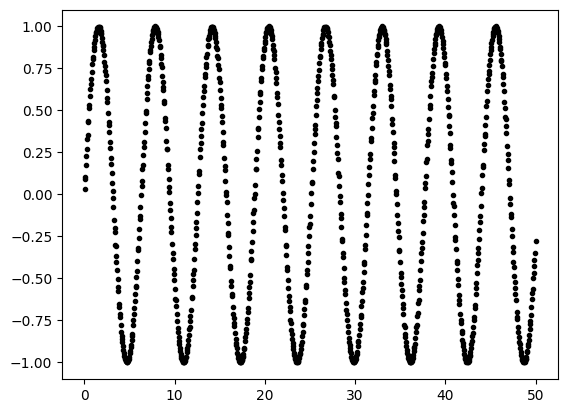

In [185]:
X = simulator.sample_inputs(1000)
Y = simulator.sample(X)
plt.scatter(X, Y, marker='.', c='k')
plt.show()

To use the emulator, simply create an instance of the provided emulator class. The key operations are:
1. **Training:** The emulator is trained on batches of inputs and outputs.
2. **Prediction:** It generates output predictions (and associated uncertainties) from new input batches.

Here we simply use a Gaussian process from the main part of the AutoEmulate package.

In [186]:
# Define an emulator using a dummy Gaussian Process.
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit_forward(self, X: torch.Tensor, Y: torch.Tensor):
        self.model.fit(X, Y)
    def sample_forward(self, X: torch.Tensor):
        return torch.from_numpy(np.array(self.model.predict(X, return_std=True)))

Let's get a feel for it.

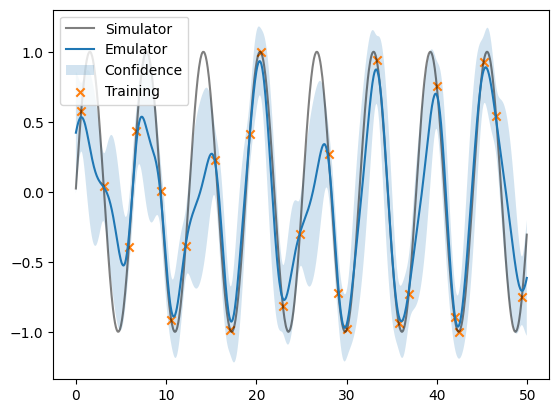

In [187]:
# Train emulator
simulator = Sin()
X_train = simulator.sample_inputs(25).sort(axis=0).values
Y_train = simulator.sample(X_train)
emulator = GP()
emulator.fit(X_train, Y_train)

# Test emulator
X_test = simulator.sample_inputs(1000).sort(axis=0).values
Y_mean, Y_cov = emulator.sample(X_test)
Y_true = simulator.sample(X_test)

# Plot
X_train, Y_train, X_test, Y_mean, Y_cov, Y_true = (
    X_train.flatten(), Y_train.flatten(), X_test.flatten(), 
    Y_mean.flatten(), Y_cov.flatten(), Y_true.flatten()
)
plt.plot(X_test, Y_true, label='Simulator', alpha=0.5, c='k')
plt.plot(X_test, Y_mean, label='Emulator')
plt.fill_between(X_test, Y_mean - Y_cov, Y_mean + Y_cov, alpha=0.2, label='Confidence')
plt.scatter(X_train, Y_train, label='Training', marker='x')
plt.legend()

### Learners

One of the simplest forms of stream-based active learning is to just sample a queried input point with some probability. Inevitably, this results in a query rate of that probability, where the query rate is the proportion of accepted input points and total input points encountered. We can instantiate and train this learner as follows.

In [188]:
# Learner components
simulator = Sin()
emulator = GP()
X_train = simulator.sample_inputs(5)
Y_train = simulator.sample(X_train)

# Learner itself!
learner = stream.Random(
    simulator=simulator,
    emulator=emulator,
    X_train=X_train,
    Y_train=Y_train,
    p_query=0.2
)

# Stream of 500 samples
X_stream = simulator.sample_inputs(500)
learner.fit_samples(X_stream)

Random: 100%|██████████| 500/500 [00:14<00:00, 35.10it/s, mse=0.0798, r2=0.836, rate=0.214, logdet=-4.25, trace=0.0143, max_eigval=0.0143, n_queries=107]


In [190]:
learner.metrics.keys()

dict_keys(['mse', 'r2', 'rate', 'logdet', 'trace', 'max_eigval', 'n_queries'])

There are several metrics commonly recorded when running an active learner, each providing insight into different aspects of its performance:

1. **`mse` (Mean Squared Error)**: Measures the average squared difference between the emulator's predicted outputs and the simulator's actual outputs before updating (fitting) the emulator. A lower MSE indicates that the emulator predictions closely match the simulator.

2. **`r2` (Coefficient of Determination)**:  
   $$
   R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
   $$  
   Here, $y_{\text{true}}$ denotes the simulator outputs, $y_{\text{pred}}$ denotes the emulator's predictions, and $\bar{y}$ is the average of the simulator's outputs.

   - An $R^2$ score of **1** indicates a perfect fit—emulator predictions exactly match simulator outputs.
   - An $R^2$ score of **0** means the emulator is performing no better than a naive model that predicts the mean simulator output.
   - An $R^2$ score **less than 0** suggests the emulator predictions are worse than simply using the mean output.

3. **`rate` (Query Rate)**: The ratio of simulator queries made to the total number of input points encountered in the stream. Lower rates indicate a more efficient learner, as fewer expensive simulator queries are needed relative to the number of inputs seen.

4. **`n_queries` (Number of Queries)**: The cumulative count of how many times the simulator has been queried so far. Monitoring this number helps track the overall computational cost incurred by the learner.

5. **`logdet` (Log Determinant of Covariance)**: Represents uncertainty in the emulator’s predictions, calculated as the log determinant of the emulator’s covariance matrix. A decreasing (more negative) log determinant typically indicates increasing confidence in predictions as the emulator improves with additional simulator data.

6. **`trace` (Trace of Covariance)**: Measures the sum of variances along each dimension of the emulator's predictions, given by the trace of the covariance matrix. As the emulator learns, this metric should decrease toward zero, reflecting growing certainty.

7. **`max_eigval` (Maximum Eigenvalue of Covariance)**: Indicates the largest single uncertainty direction of the emulator’s predictions. A decreasing maximum eigenvalue approaching zero implies increased confidence in the emulator’s predictions along all directions in the output space.


Let's plot these!

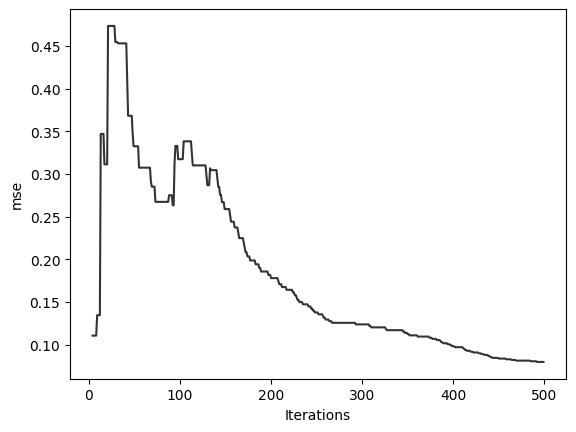

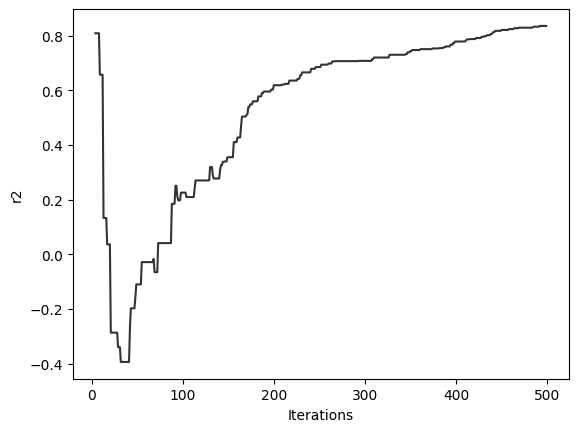

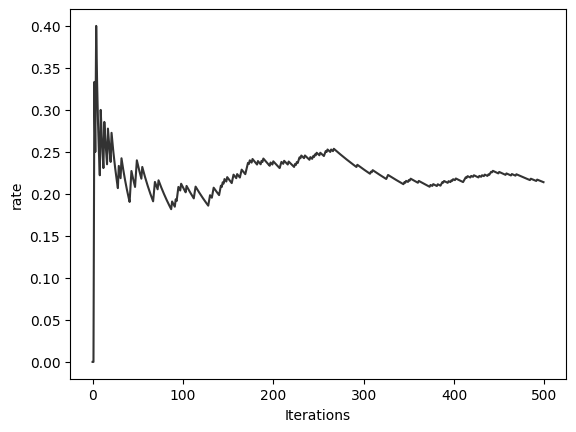

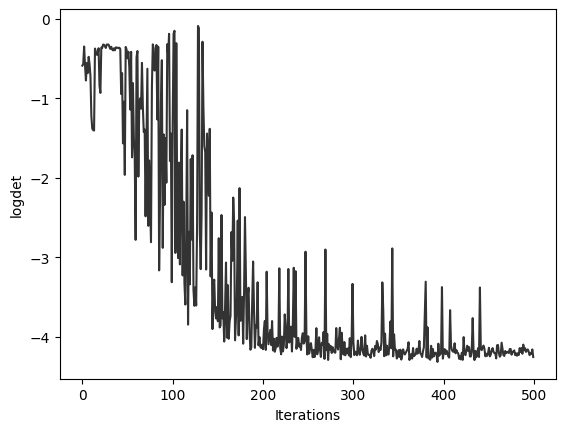

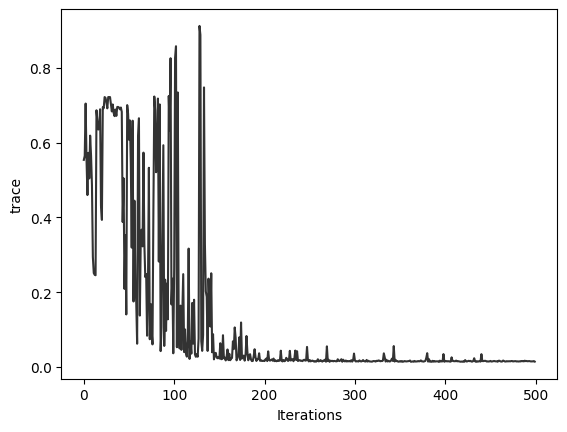

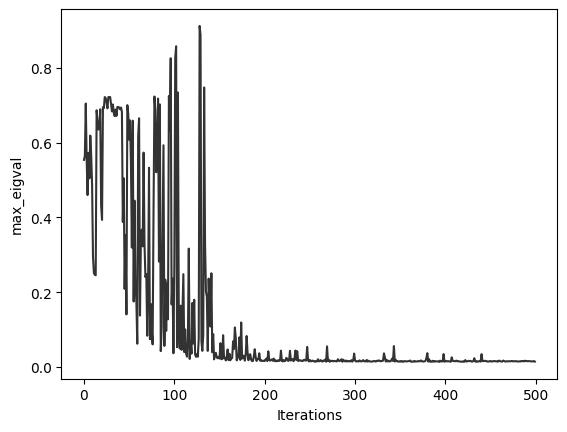

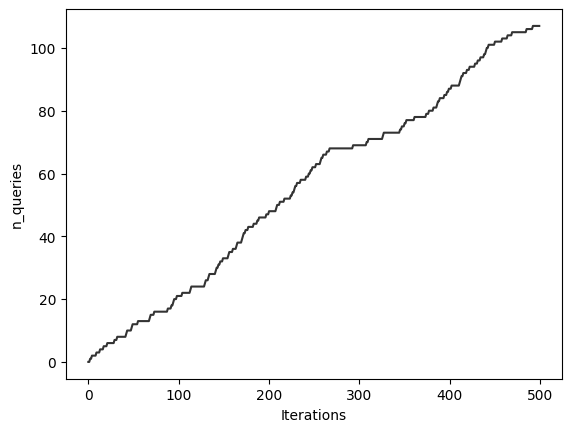

In [191]:
for k, v in learner.metrics.items():
    plt.plot(v, c='k', alpha=0.8)
    plt.xlabel('Iterations')
    plt.ylabel(k)
    plt.show()

Along with the above running statistics, we also have summary statistics available from the active learner object.
- **`mse_per_query`:**  
  This represents the mean squared error (MSE) per simulator query. A lower value indicates the emulator is closely matching the simulator’s output on average each time it's queried, suggesting good predictive performance.

- **`r2_per_query`:**  
  The coefficient of determination ($R^2$) per simulator query measures how well emulator predictions explain the variability in the simulator outputs. An $R^2$ value close to 0 suggests that emulator predictions are currently only slightly better than simply predicting the mean.

- **`trace_per_query`:**  
  This metric  is the trace of the emulator’s covariance matrix per query, reflecting the average uncertainty across the emulator’s predicted dimensions. A small value means that, on average, the emulator is very certain about its predictions at the time of querying.

- **`logdet_per_query`:**  
  The log determinant of the covariance per query quantifies the overall uncertainty volume in the emulator’s predictions. A negative and decreasing value typically indicates increased confidence and improved stability in emulator predictions.

- **`max_eigval_per_query`:**  
  The maximum eigenvalue of the covariance matrix per query indicates uncertainty along the dimension with the highest variance. A small value signifies that even in the direction of greatest uncertainty, predictions remain relatively confident.

- **`auc_mse`:**  
  The Area Under the Curve (AUC) of the cumulative mean squared error summarizes the emulator’s predictive error over the entire learning process. A lower AUC-MSE generally indicates better overall emulator performance across queries.

In [192]:
learner.summary

{'mse_per_query': 0.0007461079009817455,
 'r2_per_query': 0.007813847851759323,
 'trace_per_query': 0.00013319773494452502,
 'logdet_per_query': -0.039727541780015405,
 'max_eigval_per_query': 0.00013319773494452502,
 'auc_mse': 19.805278778076172}

## Stream-Based Active Learning Experiment (Advanced)

In this section we will perform a full experiment on all the available stream-based active learners in AutoEmulate, on both the Sin and Projectile simulations. The following instantiates an iterator of active learner instances. Feel free to tweak the parameters.

In [3]:
def learners(*, simulator: Simulator, n_initial_samples: int, adaptive_only: bool) -> Iterable:
    X_train = simulator.sample_inputs(n_initial_samples)
    Y_train = simulator.sample(X_train)
    yield stream.Random(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        p_query=0.25
    )
    if not adaptive_only:
        yield stream.Distance(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=0.5
        )
        yield stream.A_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
        yield stream.D_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=-4.2
        )
        yield stream.E_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
    yield stream.Adaptive_Distance(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=0.5, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=2.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_A_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=1e-1, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_D_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=-4.0, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=-5 if isinstance(simulator, Sin) else None, 
        max_threshold=0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_E_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=0.75 if isinstance(simulator, Sin) else 1000, 
        Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )

In the following, we create a function that runs an experiment over all stream-based active learners for a particular simulator. Note that we can specify a batch size in case batch-mode is desired.

In [150]:
def run_experiment(
    *,
    simulator: Simulator,
    seeds: List[int],
    n_initial_samples: int,
    n_stream_samples: int,
    adaptive_only: bool,
    batch_size: int | None = None
) -> Tuple[List[Dict], List[Dict]]:
    metrics, summary = list(), list()
    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        X_stream = simulator.sample_inputs(n_stream_samples)
        tqdm.write(f"Trial with seed {seed}")
        for learner in learners(
            simulator=simulator, 
            n_initial_samples=n_initial_samples, 
            adaptive_only=adaptive_only
        ):
            if batch_size is not None:
                learner.fit_batches(X_stream, batch_size)
            else:
                learner.fit_samples(X_stream)
            metrics.append(dict(
                name=learner.__class__.__name__,
                **learner.metrics
            ))
            summary.append(dict(
                name=learner.__class__.__name__,
                **learner.summary
            ))
    return metrics, summary

Here we compute the statistic over the summary metrics supplied by each learner.

In [151]:
def compute_statistics(summary: List[Dict]) -> pd.DataFrame:
    df = pd.DataFrame(summary).groupby('name').agg(['mean', 'std'])
    df = df.sort_values(('mse_per_query', 'mean'), ascending=True).round(6)
    return df

In [7]:
def plot_metrics(metrics: List[Dict], smoothing_window=10):

    # Compute the mean and variance curves for each class
    def mean(s): return np.vstack(s).mean(axis=0).tolist()
    def std(s):  return np.vstack(s).std(axis=0).tolist()
    df = pd.DataFrame(metrics).groupby("name").agg([mean, std])

    # Smoothing to help visualisation
    def moving_average(data, window):
        pad_width = window // 2
        padded_data = np.pad(data, (pad_width, window - pad_width - 1), mode='edge')
        return np.convolve(padded_data, np.ones(window)/window, mode='valid')
    
    # Plot each metric
    for metric in df.columns.get_level_values(0).unique():
        for learner in df.index:
            mean_values = moving_average(np.array(df.loc[learner, (metric, "mean")]), window=smoothing_window)
            std_values  = moving_average(np.array(df.loc[learner, (metric, "std")]), window=smoothing_window)
            iterations = np.arange(len(mean_values))
            plt.plot(iterations, mean_values, label=learner if len(mean_values) != 1 else None)
            plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, alpha=0.2)
        if metric == 'r2':
            plt.ylim(-1, 1)
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Active learning with the Sinusoid simulation

In [8]:
metrics, summary = run_experiment(
    simulator=Sin(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 33.20it/s, mse=0.0762, r2=0.853, rate=0.25, logdet=-4.19, trace=0.0151, max_eigval=0.0151, n_queries=125, score=0.0151, threshold=1, error_prop=0.000501, error_int=0.0279, error_deriv=-0.000503]      

Trial with seed 1



Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 32.54it/s, mse=0.0705, r2=0.857, rate=0.24, logdet=-4.21, trace=0.0149, max_eigval=0.0149, n_queries=120, score=0.0149, threshold=0.228, error_prop=-0.00952, error_int=-0.0732, error_deriv=-0.000483]  


In [9]:
compute_statistics(summary)

mse_per_query           r2_per_query            \
                            mean       std         mean       std   
name                                                                
Adaptive_A_Optimal      0.000578  0.000044     0.006979  0.000214   
Adaptive_Distance       0.000580  0.000030     0.007192  0.000109   
Adaptive_E_Optimal      0.000599  0.000015     0.006984  0.000220   
Random                  0.000680  0.000089     0.006948  0.000146   
Adaptive_D_Optimal      0.000754  0.000205     0.006694  0.000310   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_A_Optimal        0.000130  0.000013        -0.033464  0.000083   
Adaptive_Distance         0.000123  0.000004        -0.035500  0.000300   
Adaptive_E_Optimal        0.000123  0.000002        -0.034297  0.001094   
Random                    0.000123  0.000010        -0.035010  0.001092   
Adaptive_D_Optimal        0.000125  0.000015        -0.033868  0.002127   

                   max_eigval_per_query              auc_mse            
                                   mean       std       mean       std  
name                                                                    
Adaptive_A_Optimal             0.000130  0.000013  22.263459  3.414147  
Adaptive_Distance              0.000123  0.000004  21.916409  0.060503  
Adaptive_E_Optimal             0.000123  0.000002  23.050900  2.300537  
Random                         0.000123  0.000010  24.750525  2.083639  
Adaptive_D_Optimal             0.000125  0.000015  27.011647  1.534821

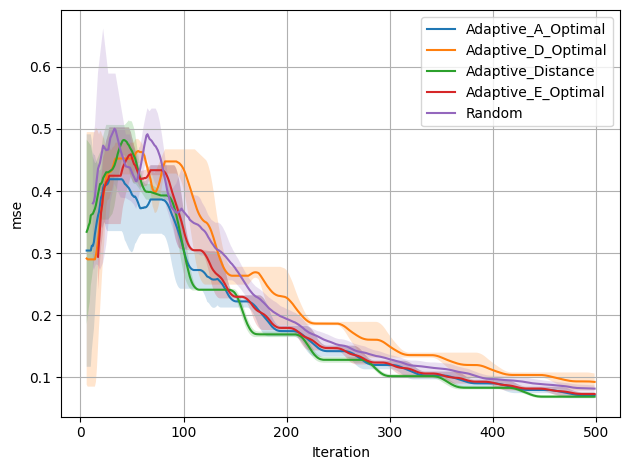

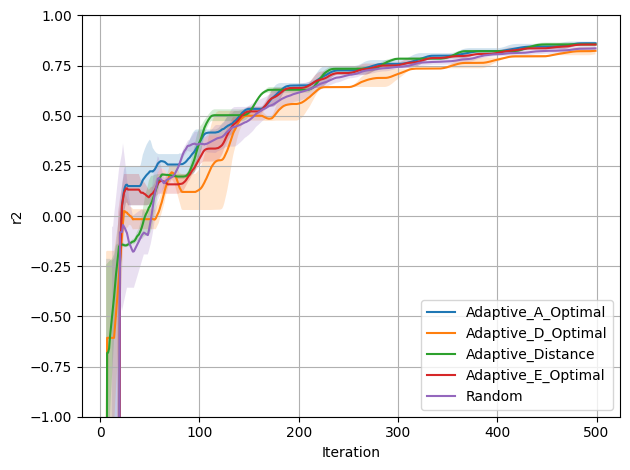

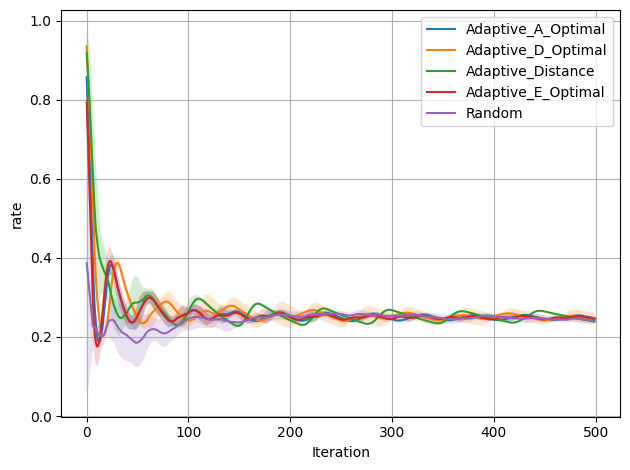

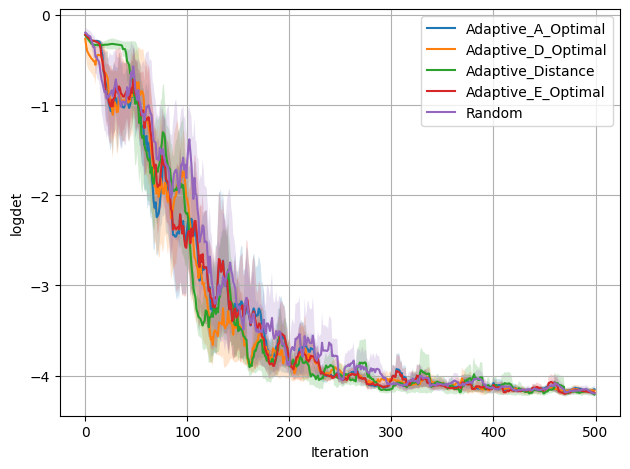

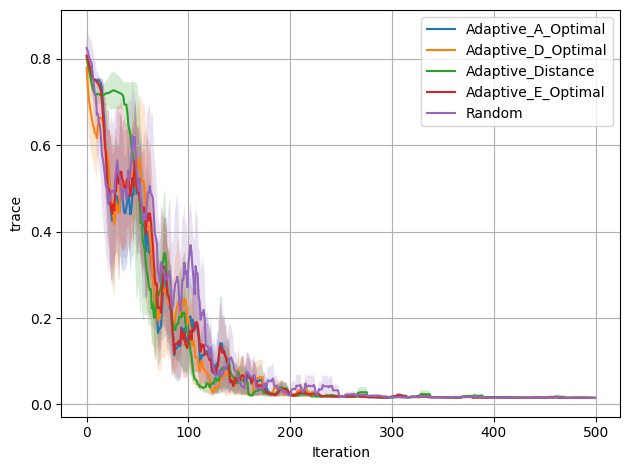

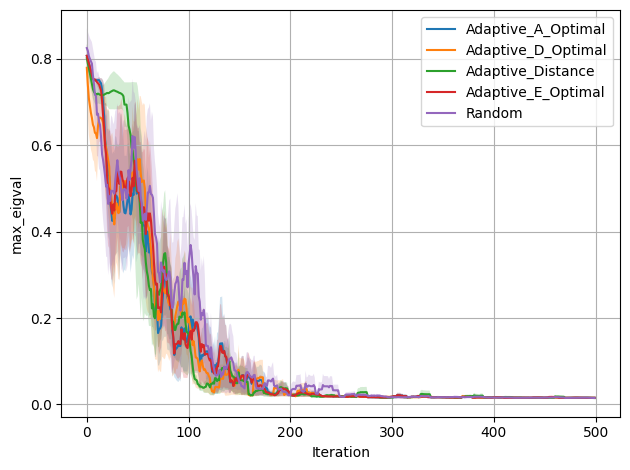

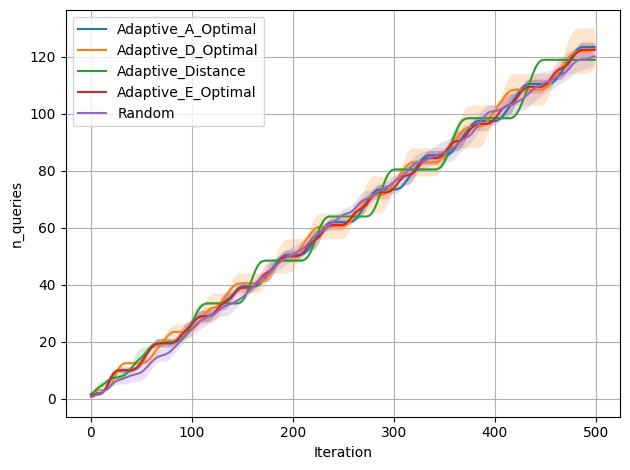

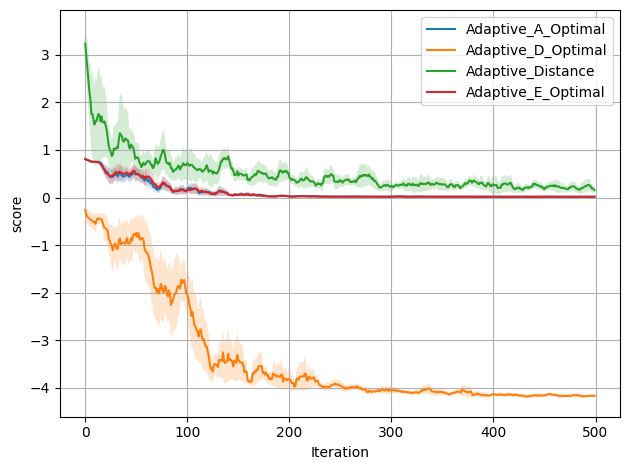

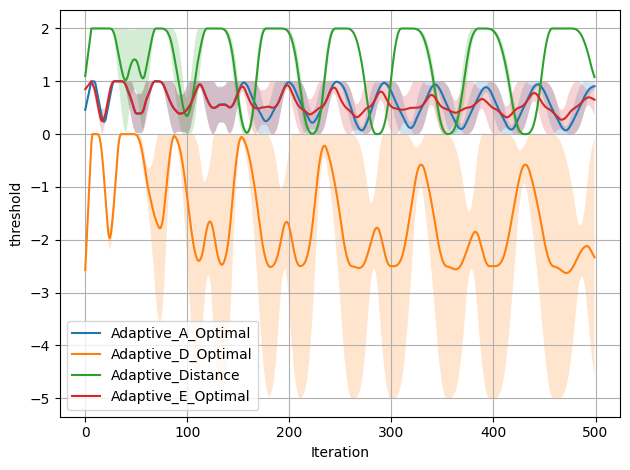

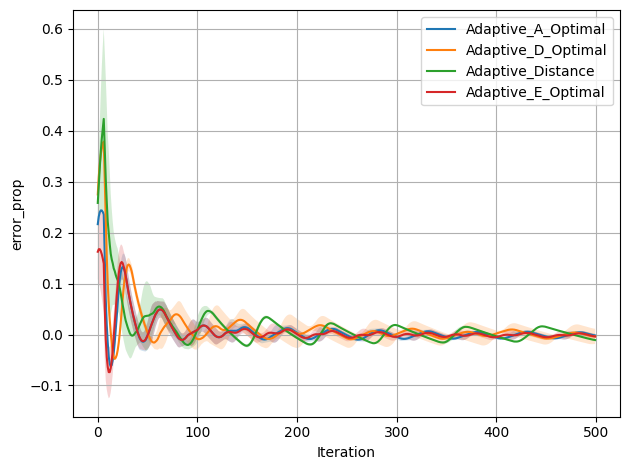

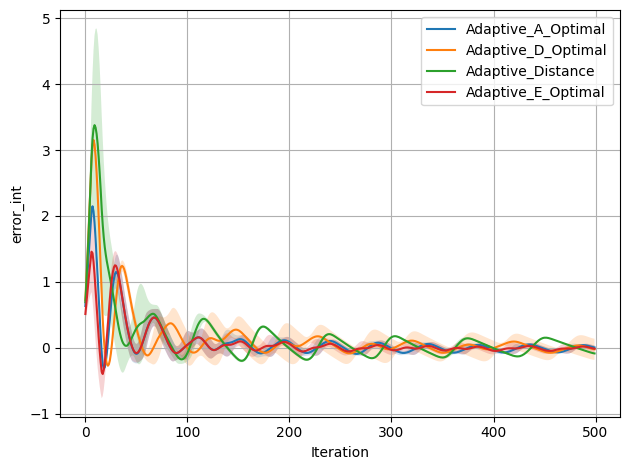

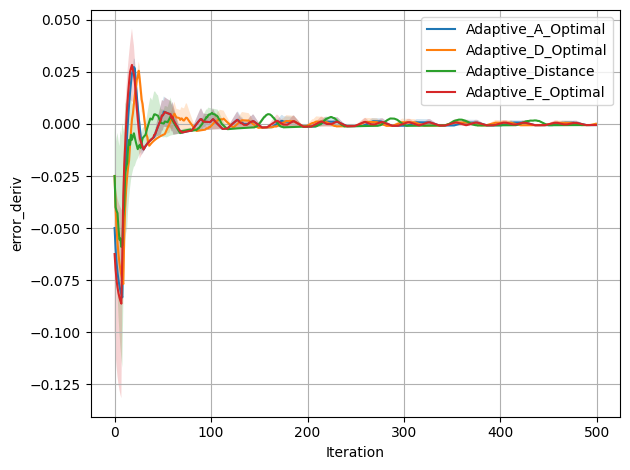

In [10]:
plot_metrics(metrics)

### Active learning with the Projectile simulation

In [11]:
metrics, summary = run_experiment(
    simulator=Projectile(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s, mse=2.28e+7, r2=0.466, rate=0.566, logdet=11.4, trace=2.81e+3, max_eigval=2.78e+3, n_queries=283, score=2.78e+3, threshold=4.51e+3, error_prop=0.317, error_int=3.22, error_deriv=-0.00114]

Trial with seed 1



Adaptive_E_Optimal: 100%|██████████| 500/500 [01:00<00:00,  8.26it/s, mse=2.58e+7, r2=0.45, rate=0.56, logdet=10.1, trace=1.43e+3, max_eigval=1.41e+3, n_queries=280, score=1.41e+3, threshold=4.51e+3, error_prop=0.311, error_int=3.15, error_deriv=-0.00113]   


In [12]:
compute_statistics(summary)

mse_per_query                r2_per_query            \
                             mean            std         mean       std   
name                                                                      
Adaptive_A_Optimal   67393.664134    1431.239792     0.001588  0.000080   
Adaptive_E_Optimal   86495.646553    8208.666490     0.001627  0.000030   
Adaptive_D_Optimal  165009.676497   21862.791875     0.001769  0.000674   
Random              217131.999765  105996.444282     0.001643  0.001482   
Adaptive_Distance   255476.250904    8301.686570     0.000873  0.000705   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_A_Optimal        5.900740  3.491901         0.032598  0.004055   
Adaptive_E_Optimal        7.521685  3.417059         0.038244  0.002843   
Adaptive_D_Optimal       23.764620  9.174982         0.072524  0.004835   
Random                   37.615458  5.060386         0.101070  0.003884   
Adaptive_Distance        50.325485  7.517982         0.110126  0.009696   

                   max_eigval_per_query                 auc_mse                
                                   mean       std          mean           std  
name                                                                           
Adaptive_A_Optimal             5.834769  3.459241  9.341832e+09  1.001667e+09  
Adaptive_E_Optimal             7.433152  3.383011  8.669629e+09  8.512731e+08  
Adaptive_D_Optimal            23.487168  9.054846  5.469292e+09  1.406554e+09  
Random                        37.151451  5.096577  2.836627e+09  6.783562e+08  
Adaptive_Distance             49.599573  7.417038  4.008987e+09  2.142902e+09

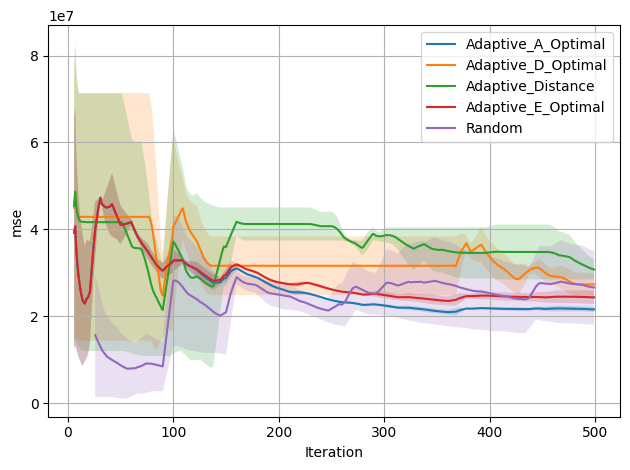

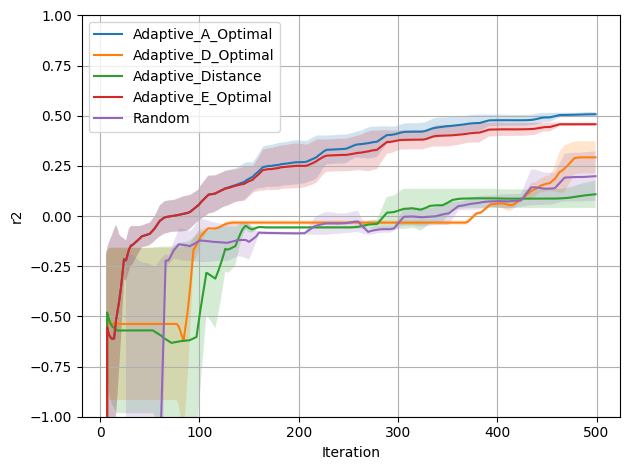

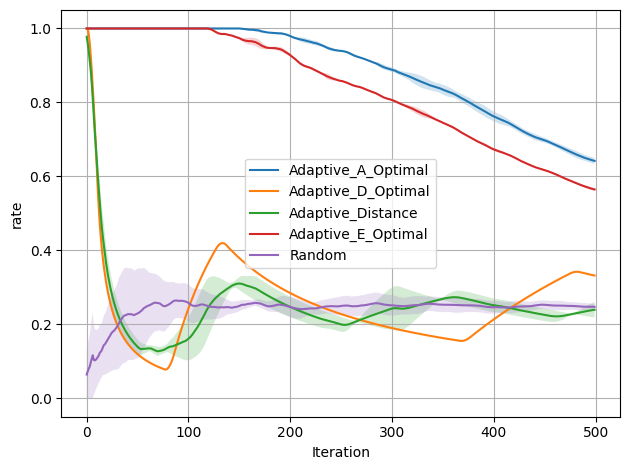

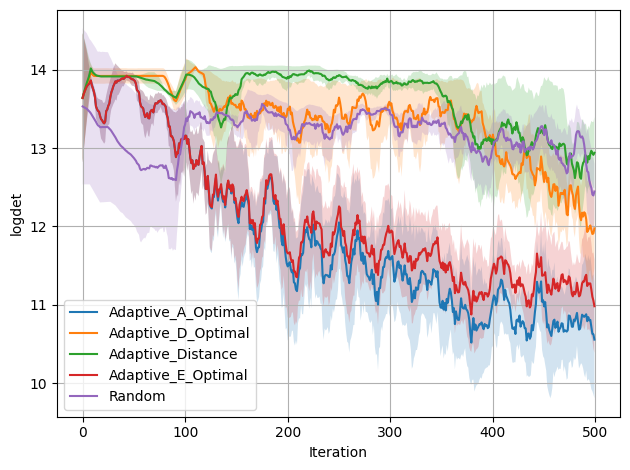

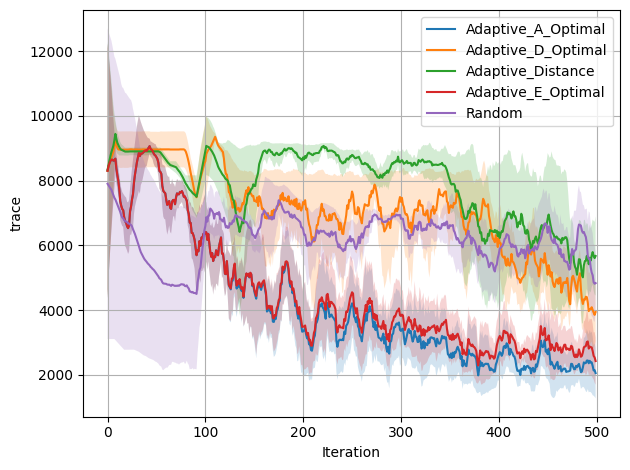

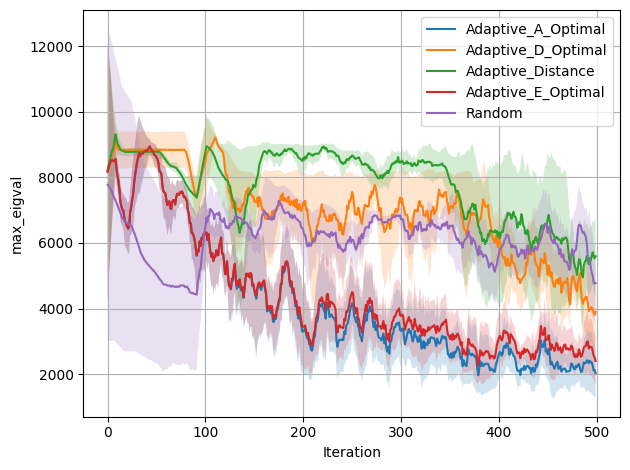

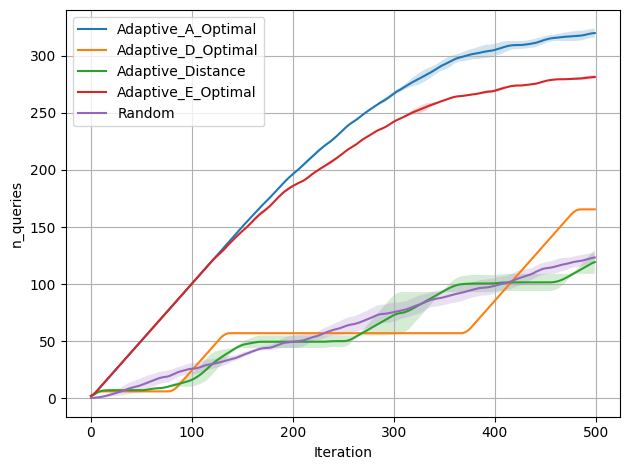

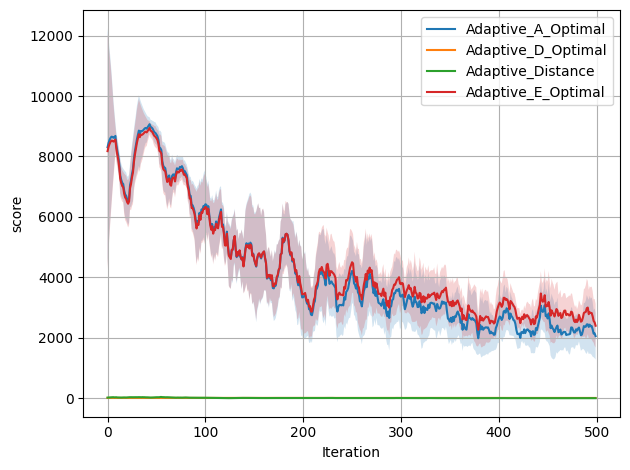

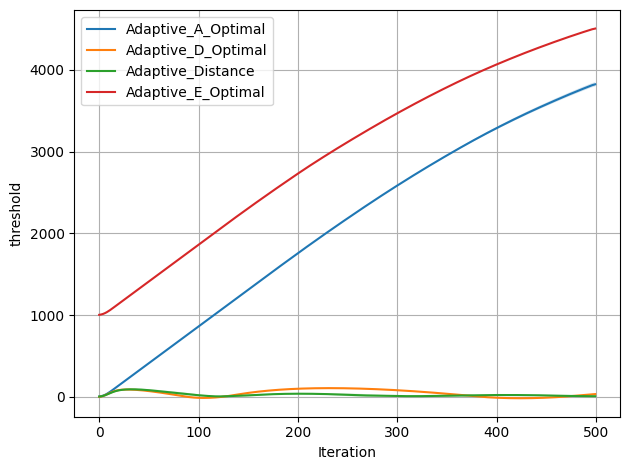

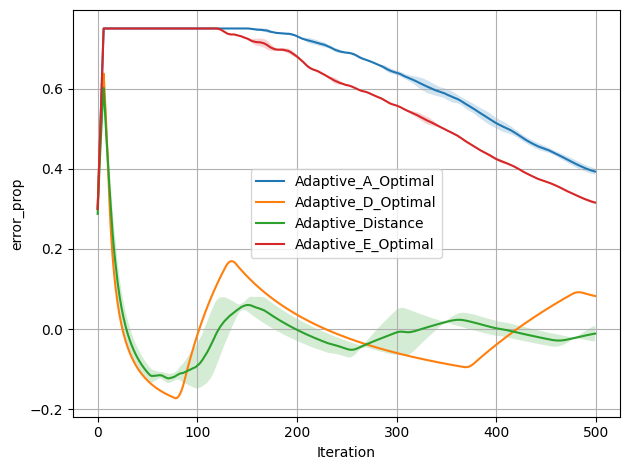

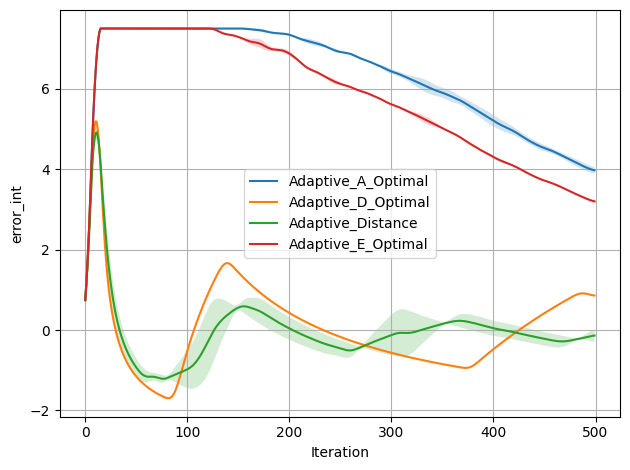

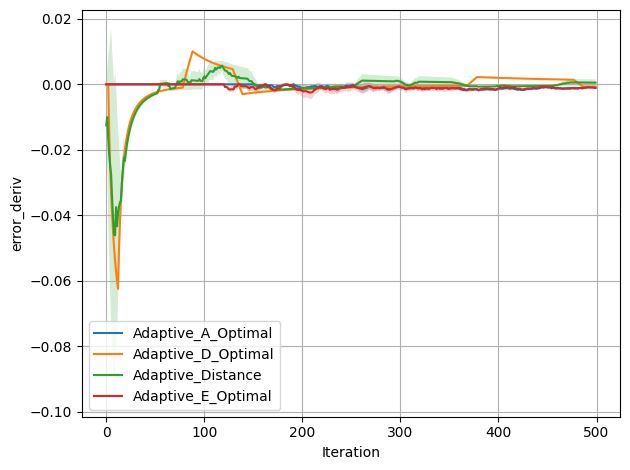

In [13]:
plot_metrics(metrics)